In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def format(mirror: str) -> int:

    m, n = mirror[:2], int(mirror[2:])

    if m == 'll': n+= 0
    if m == 'lm': n+= 6
    if m == 'la': n+= 12
    if m == 'co': n+= 18
    if m == 'he': n+= 24

    return n

/tmp/ipykernel_13261/1311103407.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(cal_xy / cal_std, positions=[format(run['telescope'].strip())], vert=False,
/tmp/ipykernel_13261/1311103407.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(cal_xy / cal_std, positions=[format(run['telescope'].strip())], vert=False,
/tmp/ipykernel_13261/1311103407.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(cal_xy / cal_std, positions=[format(run['telescope'].strip())], vert=False,
/tmp/ipykernel_13261/1311103407.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has 

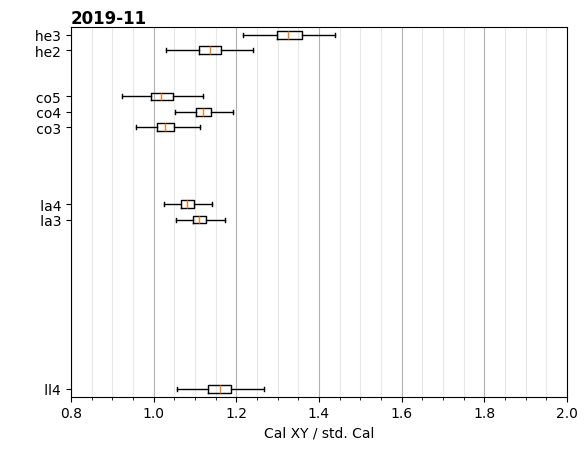

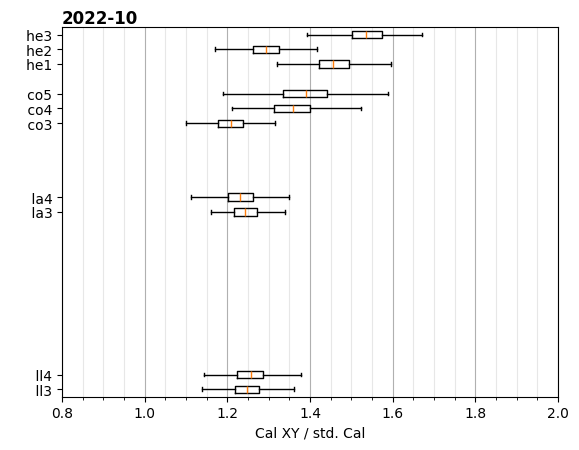

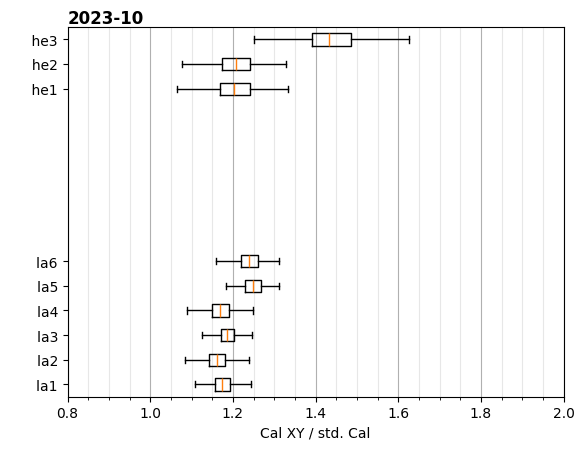

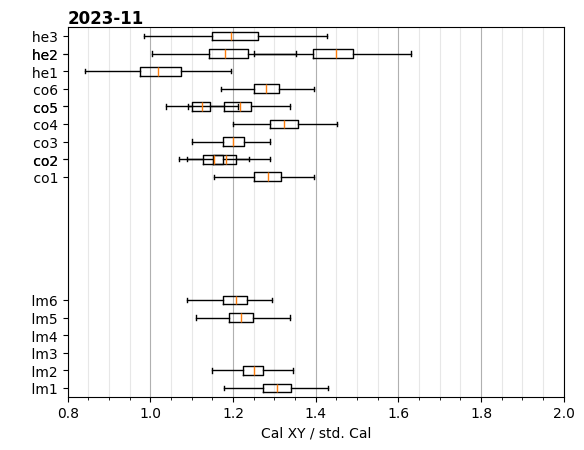

In [29]:
runlist_dir = '/home/filip/xy-calibration/config/calib_runlists/'
source_dir = '/home/filip/xy-calibration/results/'

# fig, axes = plt.subplots(4, 1, sharex=True)

axes = [plt.subplots()[1] for _ in range(4)]

for ax, list in zip(axes, ['2019-11', '2022-10', '2023-10', '2023-11']):

    ax.set_xticks(np.arange(0.8, 2.0, 0.05), minor=True)   # set minor ticks on x-axis

    ax.text(0, 1, list, transform=ax.transAxes,
            ha='left', va='bottom', fontsize='large', fontweight='bold')
    ax.set_xlabel(r"Cal XY / std. Cal")
    ax.set_xlim(0.8, 2.0)
    ax.grid(axis='x')
    ax.grid(axis='x', which='minor', alpha=0.3)

    with open(f'{runlist_dir}calib_runs_{list}.list', 'r') as f:
        header = f.readline().strip().split(';')

    df = pd.read_csv(f'{runlist_dir}/calib_runs_{list}.list',
                     comment='#', delimiter=';', names=header)
    
    for i, run in df.iterrows():
        if not run['forDB']: continue
        if not run['source'].strip() in ['"OLO"', "OLO"]: continue
        if not run['comment'].strip() != '': continue

        try:
            # pixel calibConst adcSum stdCalib calibConstCorr
            cal_xy, cal_std, cal_xy_corr = np.loadtxt(f'{source_dir}/outCorr_{run["#runid"]}.txt', usecols=[1, 3, 4], unpack=True)
            ax.boxplot(cal_xy / cal_std, positions=[format(run['telescope'].strip())], vert=False, 
                       labels=[run['telescope']], showfliers=False, widths=0.5)
        except FileNotFoundError: continue

    # raise StopIteration